# Introduction

#### In this project we will help people who are looking for renting an apartment in Vienna. If they are looking to move to Vienna they can see:
<ul>
<li> Which district has cheaper rent or,
<li> They can choose to live in residential or commercial areas and can see for example which residential districts is best
</ul>

#### Or, if they already live in one of the 23 districts in Vienna they will be able to see: 
<ul>
<li> If they are paying more than the average price for their apartment  
<li> If there are similar districts to theirs with lower rents
</ul>

# Data

#### The data on apartments (size, number of rooms, address, and price) is collected by scraping a local website with apartment listings (willhaben.at). Using geopy we find the coordinates for each district and then using Foursquare we collect the closest venues (supermarket, restaurant, park, etc.). After the data collection we can run k-means clustering to cluster the districts into residential and commercial areas and visualize all the data on a single choropleth map. 

### Load dependencies

In [1]:
import pandas as pd
import numpy as np

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.distance import great_circle

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import json # library to handle JSON files

import requests # library to handle requests
from requests import get

from bs4 import BeautifulSoup

import re

from time import sleep

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import seaborn as sns

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

## 1. Scraping willhaben.at for apartments data in Vienna

#### Extract relevant data (Postal Code, District, Size in m2, number of rooms, and Price) by looping through all pages until no more listings are found

In [2]:
listing_found = True
page_num = 1
listings = []

while listing_found:
    
    # define header to make the request look like it's comming from an actual browser
    headers = {'User-agent': 'Googlebot'}
    
    # set url 
    url = 'https://www.willhaben.at/iad/immobilien/mietwohnungen/mietwohnung-angebote?areaId=900&page={}&rows=200'.format(page_num)
    
    # load the response
    response = get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # find all outer containers of listings
    apartment_containers = soup.find_all('section', class_="content-section isRealestate")
    
    # check if page contains listings
    if len(apartment_containers) == 0:
        break
    
    # for each apartment extract relevant data
    for apt in apartment_containers:
        try:
            info = apt.find_all('div', class_="info")[0]

            try:
                size = info.find_all('span', class_="desc-left")[0].text.split()[0]
            except:
                size = np.nan

            try:
                rooms = info.find_all('span', class_="desc-left")[0].text.split()[2]
            except:
                rooms = np.nan

            try:
                price = info.find_all('span', class_="pull-right")[0].text.split()[0]
            except:
                price = np.nan

        except:
            size, rooms, price = np.nan

        try:
            full_address = apt.find_all('div', class_="address-lg w-brk-ln-1")[0].text.split()
            full_address = ' '.join(full_address)

            postal_code = re.search('1\d\d0', full_address)[0]
            district = full_address.split(', ')[-1]

            if address == None:
                address = None
            else:
                address = address[1]

                if len(address.split(', ')) > 1:
                    address = address.split(', ')[0]
        except:
            address = None
            postal_code = None
            district = None

        listings.append([postal_code, district, size, rooms, price])
    
    # increase page number
    page_num += 1
    
    # set sleep to mimic a more human behaviour and don't overload the site with requests
    sleep(np.random.randint(1,3))

#### set column names and build a dataframe from previous results

In [3]:
column_names = ['PostalCode', 'District', 'Size', 'Rooms', 'Price']
rental_properties = pd.DataFrame(listings, columns=column_names)

In [4]:
print('There are {} apartments in the dataset'.format(rental_properties.shape[0]))

There are 11310 apartments in the dataset


In [5]:
rental_properties.head()

,PostalCode,District,Size,Rooms,Price
0,None,None,97,3,"1.399,-"
1,1030,Landstraße,92,3,"1.449,-"
2,1030,Landstraße,93,3,"1.449,01"
3,1030,Landstraße,82,3,"1.349,-"
4,1030,Landstraße,81,3,"1.375,-"


## 2. Pre-process & Visualize the data 

#### Adjust the data so they have the same format for each column

In [6]:
rental_properties['Size'] = rental_properties['Size'].str.replace('–', 'NaN').astype('float')
rental_properties['Rooms'] = rental_properties['Rooms'].astype('float')
rental_properties['Price'] = rental_properties['Price'].str.replace('.', '').str.replace(',', '.').str.replace('-', '00').str.replace('vermietet', 'NaN').astype('float')

#### Calculate the price per meter squared

In [7]:
rental_properties['Price/m2'] = (rental_properties['Price']/rental_properties['Size']).round(2)

In [8]:
rental_properties.head()

,PostalCode,District,Size,Rooms,Price,Price/m2
0,None,None,97.0,3.0,1399.00,14.42
1,1030,Landstraße,92.0,3.0,1449.00,15.75
2,1030,Landstraße,93.0,3.0,1449.01,15.58
3,1030,Landstraße,82.0,3.0,1349.00,16.45
4,1030,Landstraße,81.0,3.0,1375.00,16.98


In [9]:
rental_properties.describe()

,Size,Rooms,Price,Price/m2
count,11290.000000,10577.000000,11272.000000,11268.000000
mean,77.311957,2.580883,1270.111519,16.995375
std,40.873882,1.077950,2755.557646,34.854596
min,1.000000,1.000000,30.000000,0.670000
25%,50.000000,2.000000,799.000000,13.677500
50%,66.000000,2.000000,990.000000,15.890000
75%,90.000000,3.000000,1399.000000,18.172500
max,590.000000,35.000000,280000.000000,3294.120000


In [10]:
rental_properties.dtypes

PostalCode     object
District       object
Size          float64
Rooms         float64
Price         float64
Price/m2      float64
dtype: object

#### Remove rows with NA values in all columns except for the number of rooms since there are too many missing values

In [11]:
rental_properties.dropna(subset=['PostalCode', 'District', 'Size', 'Price'], inplace=True)

In [12]:
print('There are {} apartments in the dataset'.format(rental_properties.shape[0]))

There are 11266 apartments in the dataset


#### Let's check how many apartments per room number we have in our dataset

In [13]:
rental_properties['Rooms'].value_counts()

2.0     4898
3.0     3230
4.0     1190
1.0      859
5.0      257
6.0       83
7.0       26
8.0        7
9.0        1
11.0       1
35.0       1
33.0       1
14.0       1
12.0       1
Name: Rooms, dtype: int64

#### Let's remove all rows with rooms larger than 6. Apartments bigger than 6 will most likely be luxurious apartments and does not fit the target group.

In [14]:
rental_properties = rental_properties[rental_properties['Rooms'] <= 6]

#### We can visualize the number of apartments per room number and number of apartments in each district

[Text(0, 0, '1010'),
 Text(0, 0, '1020'),
 Text(0, 0, '1030'),
 Text(0, 0, '1040'),
 Text(0, 0, '1050'),
 Text(0, 0, '1060'),
 Text(0, 0, '1070'),
 Text(0, 0, '1080'),
 Text(0, 0, '1090'),
 Text(0, 0, '1100'),
 Text(0, 0, '1110'),
 Text(0, 0, '1120'),
 Text(0, 0, '1130'),
 Text(0, 0, '1140'),
 Text(0, 0, '1150'),
 Text(0, 0, '1160'),
 Text(0, 0, '1170'),
 Text(0, 0, '1180'),
 Text(0, 0, '1190'),
 Text(0, 0, '1200'),
 Text(0, 0, '1210'),
 Text(0, 0, '1220'),
 Text(0, 0, '1230')]

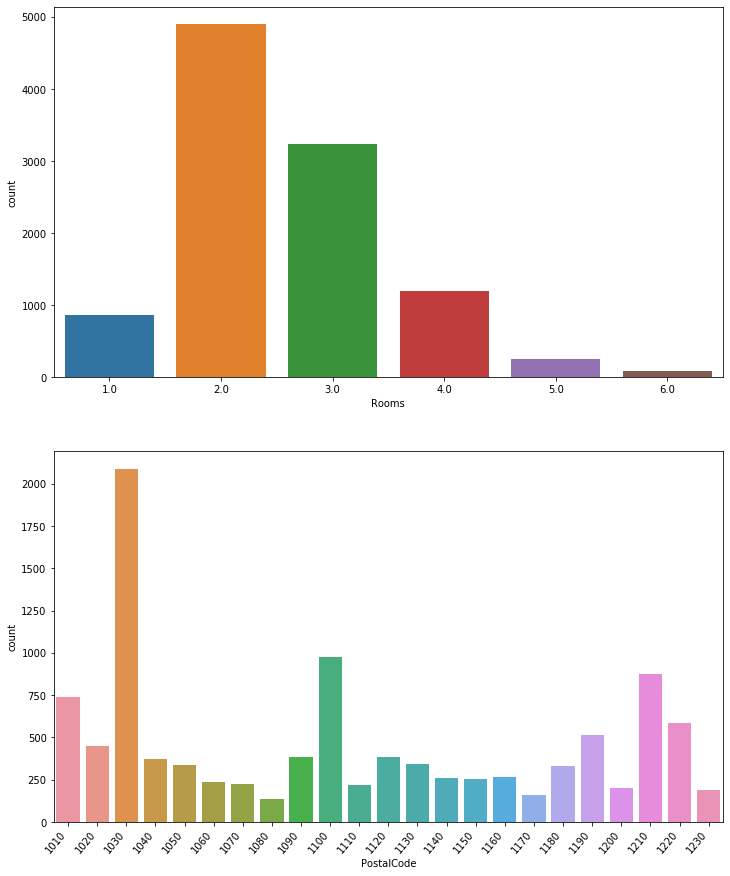

In [15]:
fig, ax =plt.subplots(2,1, figsize=(12,15))
sns.countplot(rental_properties['Rooms'], ax=ax[0])
sns.countplot(rental_properties['PostalCode'], ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=50, ha="right")

#### Plot the price and check for any outliers

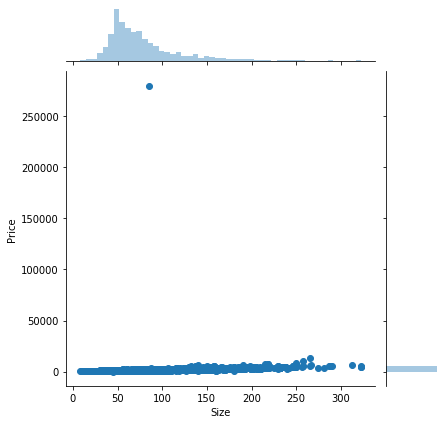

In [16]:
sns.jointplot(x='Size', y='Price', data=rental_properties[['Size','Price']])

#### Remove the outliers

In [17]:
rental_properties = rental_properties[rental_properties['Price'] <= 7000]

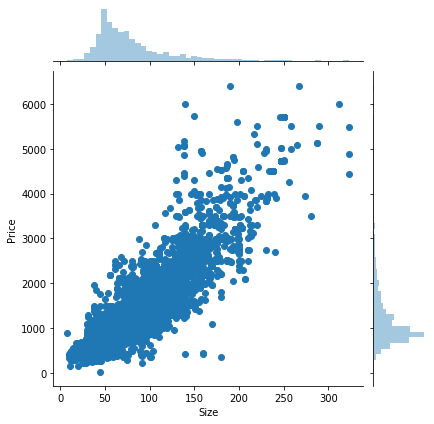

In [18]:
sns.jointplot(x='Size', y='Price', data=rental_properties[['Size','Price']])

#### We expect the value of properties to go up as the number of rooms increases. The interesting aspect in this boxplot is that 1 and 2 room apartments are competing in the same price range.

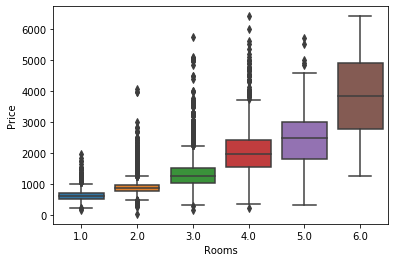

In [19]:
sns.boxplot(x='Rooms', y='Price', data=rental_properties)

#### In the following plot we can see that the price/m2 is in the same price range for all size apartments besides for single room apartments where the price/m2 goes even higher

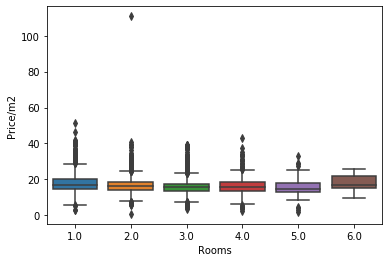

In [20]:
sns.boxplot(x='Rooms', y='Price/m2', data=rental_properties)

#### Let's also check the differences in price per m2 in each district

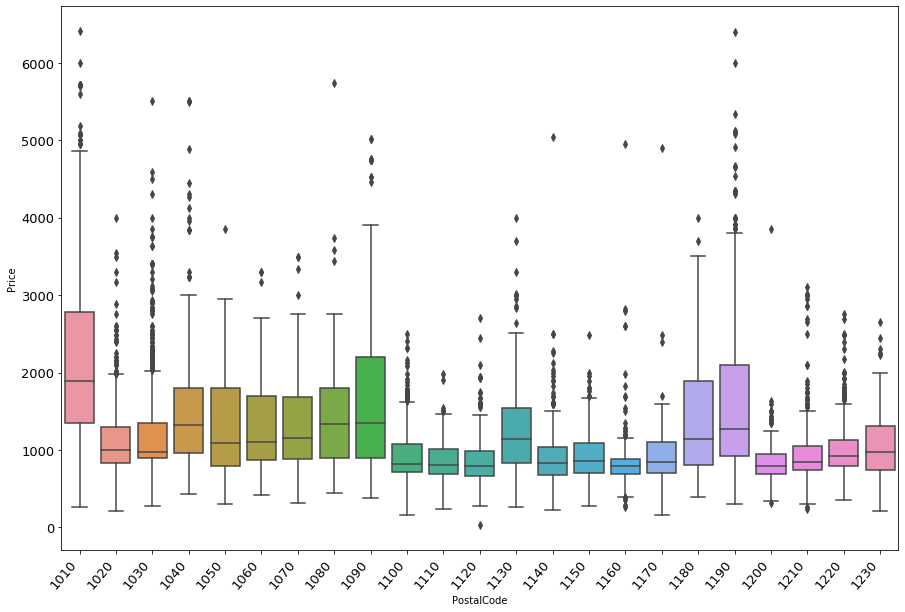

In [21]:
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='PostalCode', y='Price', data=rental_properties)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
ax.tick_params(labelsize=13)

#### Save the dataframe to a csv file (optional)

In [22]:
# vienna_districts.to_csv('district_coordinates.csv', index=False)

## 3. Get coordinates for each district

#### To avoid fetching coordinates for the same districts many times, we find the unique postal codes and find the coordinates once for each district

In [23]:
# vienna_districts = pd.read_csv('district_coordinates.csv')
# vienna_districts

In [24]:
vienna_districts = rental_properties[['PostalCode','District']].drop_duplicates().sort_values(by=['PostalCode']).reset_index(drop=True)
vienna_districts

,PostalCode,District
0,1010,Innere Stadt
1,1020,Leopoldstadt
2,1030,Landstraße
3,1040,Wieden
4,1050,Margareten
5,1060,Mariahilf
6,1070,Neubau
7,1080,Josefstadt
8,1090,Alsergrund
9,1100,Favoriten


In [25]:
latitude = np.zeros(vienna_districts.shape[0])
longitude = np.zeros(vienna_districts.shape[0])

geolocator = Nominatim(user_agent="vienna_explorer")

for idx in range(vienna_districts.shape[0]):
    address = vienna_districts['District'].loc[idx] + ', Wien'
    
    location = geolocator.geocode(address)
    latitude[idx] = location.latitude
    longitude[idx] = location.longitude

In [26]:
district_coordinates = vienna_districts
district_coordinates['Latitude'] = latitude
district_coordinates['Longitude'] = longitude
district_coordinates

,PostalCode,District,Latitude,Longitude
0,1010,Innere Stadt,48.209133,16.369992
1,1020,Leopoldstadt,48.200638,16.426895
2,1030,Landstraße,48.193644,16.396286
3,1040,Wieden,48.208354,16.372504
4,1050,Margareten,48.188073,16.353386
5,1060,Mariahilf,48.195475,16.347023
6,1070,Neubau,48.201881,16.349056
7,1080,Josefstadt,48.210598,16.351750
8,1090,Alsergrund,48.225073,16.358398
9,1100,Favoriten,48.173423,16.377914


#### We can visualize the districts on a map 

In [27]:
# create map of Vienna using latitude and longitude values
map_vienna = folium.Map(location=[48.2012167,16.3725062], zoom_start=12)

# add markers to map
for lat, lng, postalcode, district in zip(district_coordinates['Latitude'], district_coordinates['Longitude'], district_coordinates['PostalCode'], district_coordinates['District']):
    dist = postalcode[1:3]
    label = '{}. {}'.format(dist, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_vienna)  
    
map_vienna

## 4. Visualize the average price/m2 & average apartment size per district on a choropleth map

#### Extract only the Vienna districts from the JSON file and edit the keys to match our data  

JSON file from: https://github.com/ginseng666/GeoJSON-TopoJSON-Austria

In [ ]:
with open('gemeinden_wien_bezirke_geo.json') as json_data:
    location_data = json.load(json_data)

In [ ]:
location_data['features'] = location_data['features'][:23]

In [ ]:
for idx in range(len(location_data['features'])):
    location_data['features'][idx]['properties']['name'] = location_data['features'][idx]['properties']['name'].replace('Wien ','')

#### Calculate the mean per district 

In [29]:
mean_per_district = rental_properties.groupby('District').mean().reset_index()
mean_per_district.head()

,District,Size,Rooms,Price,Price/m2
0,Alsergrund,96.704961,2.890339,1666.614517,17.378277
1,Brigittenau,61.890000,2.175000,852.853650,14.390000
2,Donaustadt,65.186325,2.423932,1010.532410,16.216872
3,Döbling,94.782101,2.892996,1619.845934,16.658210
4,Favoriten,58.852308,2.369231,910.721846,15.934267


### 4.1 Average price/m2 per district

In [ ]:
# vienna_geo = r'BEZIRKSGRENZEOGD.json' # geojson file
vienna_geo = location_data

# create a plain map of Vienna
vienna_map = folium.Map(location=[48.2012167,16.3725062], zoom_start=12)

# add the data
vienna_map.choropleth(
    geo_data=location_data,
    data=mean_per_district,
    columns=['District', 'Price/m2'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average price/m2 for each district in Vienna'
)

# add markers to map
for lat, lng, postalcode, district in zip(district_coordinates['Latitude'], district_coordinates['Longitude'], district_coordinates['PostalCode'], district_coordinates['District']):
    dist = postalcode[1:3]
    label = '{}. {}'.format(dist, district)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=100,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(vienna_map) 

# display map
vienna_map

### 4.2 Average apartment size per district

In [ ]:
# vienna_geo = r'BEZIRKSGRENZEOGD.json' # geojson file
vienna_geo = location_data

# create a plain map of Vienna
vienna_map = folium.Map(location=[48.2012167,16.3725062], zoom_start=12)

# add the data
vienna_map.choropleth(
    geo_data=location_data,
    data=mean_per_district,
    columns=['District', 'Size'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average apartment size for each district in Vienna'
)

# add markers to map
for lat, lng, postalcode, district in zip(district_coordinates['Latitude'], district_coordinates['Longitude'], district_coordinates['PostalCode'], district_coordinates['District']):
    dist = postalcode[1:3]
    label = '{}. {}'.format(dist, district)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=100,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(vienna_map) 

# display map
vienna_map

## 5. Get Foursquare data

#### Define Foursquare Credentials and Version

In [32]:
# @hidden_cell
CLIENT_ID = 'G3RNVOETTALUPG4AUBQJSE0HK45GAE0RNK0OEDMMPS2IFGVJ' # your Foursquare ID
CLIENT_SECRET = 'QLNNCOTY3U2PWSDBYE04ANE20AKRAHAMMYJT4N0ESZSBMV5W' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#### Let's create a function to repeat the same process to all the districts in Vienna

In [33]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [34]:
vienna_venues = getNearbyVenues(names=district_coordinates['District'],
                                   latitudes=district_coordinates['Latitude'],
                                   longitudes=district_coordinates['Longitude'],
                                   radius=2000, LIMIT=100)

In [35]:
vienna_venues.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Innere Stadt,48.209133,16.369992,Stephansplatz,48.208299,16.371880,Plaza
1,Innere Stadt,48.209133,16.369992,Stephansdom,48.208626,16.372672,Church
2,Innere Stadt,48.209133,16.369992,Park Hyatt Vienna,48.210691,16.367788,Hotel
3,Innere Stadt,48.209133,16.369992,COS,48.209359,16.371591,Clothing Store
4,Innere Stadt,48.209133,16.369992,Zum Schwarzen Kameel,48.210010,16.368240,Austrian Restaurant


In [36]:
print('{} venues are collected'.format(vienna_venues.shape[0]))

1790 venues are collected


In [37]:
vienna_venues.groupby('District').count()

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Alsergrund,100,100,100,100,100,100
Brigittenau,100,100,100,100,100,100
Donaustadt,29,29,29,29,29,29
Döbling,63,63,63,63,63,63
Favoriten,100,100,100,100,100,100
Floridsdorf,43,43,43,43,43,43
Hernals,33,33,33,33,33,33
Hietzing,24,24,24,24,24,24
Innere Stadt,100,100,100,100,100,100


#### Let's find out how many unique categories can be curated from all the returned venues

In [38]:
print('There are {} uniques categories.'.format(len(vienna_venues['Venue Category'].unique())))

There are 211 uniques categories.


## 6. Analyze Each District

In [39]:
# one hot encoding
vienna_onehot = pd.get_dummies(vienna_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
vienna_onehot['District'] = vienna_venues['District'] 

# move neighborhood column to the first column
fixed_columns = [vienna_onehot.columns[-1]] + list(vienna_onehot.columns[:-1])
vienna_onehot = vienna_onehot[fixed_columns]

vienna_onehot.head()

,District,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,...,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Wine Bar,Wine Shop,Winery,Yoga Studio,Zoo,Zoo Exhibit
0,Innere Stadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Innere Stadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Innere Stadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Innere Stadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Innere Stadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by district and by taking the mean of the frequency of occurrence of each category

In [40]:
vienna_grouped = vienna_onehot.groupby('District').mean().reset_index()
vienna_grouped

,District,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,...,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Wine Bar,Wine Shop,Winery,Yoga Studio,Zoo,Zoo Exhibit
0,Alsergrund,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,...,0.01,0.00000,0.01,0.000000,0.010000,0.000000,0.000000,0.00,0.00,0.000000
1,Brigittenau,0.00,0.00,0.00,0.00,0.00,0.000000,0.020000,0.000000,0.00,...,0.00,0.00000,0.00,0.000000,0.000000,0.010000,0.020000,0.00,0.00,0.000000
2,Donaustadt,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,...,0.00,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000
3,Döbling,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,...,0.00,0.00000,0.00,0.031746,0.079365,0.000000,0.015873,0.00,0.00,0.015873
4,Favoriten,0.00,0.00,0.00,0.03,0.00,0.000000,0.050000,0.000000,0.00,...,0.00,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000
5,Floridsdorf,0.00,0.00,0.00,0.00,0.00,0.000000,0.023256,0.023256,0.00,...,0.00,0.00000,0.00,0.023256,0.023256,0.023256,0.000000,0.00,0.00,0.000000
6,Hernals,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,...,0.00,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000
7,Hietzing,0.00,0.00,0.00,0.00,0.00,0.000000,0.083333,0.000000,0.00,...,0.00,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000
8,Innere Stadt,0.00,0.01,0.00,0.01,0.02,0.000000,0.020000,0.000000,0.01,...,0.01,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000
9,Josefstadt,0.00,0.01,0.01,0.00,0.03,0.000000,0.020000,0.000000,0.01,...,0.01,0.00000,0.02,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000


#### First, let's write a function to sort the venues in descending order.

In [41]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Now let's create a new dataframe and display the top 10 venues for each district.

In [42]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for idx in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(idx+1, indicators[idx]))
    except:
        columns.append('{}th Most Common Venue'.format(idx+1))

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = vienna_grouped['District']

for idx in np.arange(vienna_grouped.shape[0]):
    district_venues_sorted.iloc[idx, 1:] = return_most_common_venues(vienna_grouped.iloc[idx, :], num_top_venues)

In [43]:
district_venues_sorted

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alsergrund,Café,Coffee Shop,Restaurant,Park,Hotel,Italian Restaurant,Tapas Restaurant,Bar,BBQ Joint,Pub
1,Brigittenau,Supermarket,Austrian Restaurant,Plaza,Italian Restaurant,Park,Restaurant,Hotel,Gym,Ice Cream Shop,Nightclub
2,Donaustadt,Bus Stop,Supermarket,Bakery,Gastropub,Fast Food Restaurant,Breakfast Spot,Metro Station,Garden Center,Garden,Soccer Field
3,Döbling,Restaurant,Austrian Restaurant,Café,Wine Bar,Italian Restaurant,Scenic Lookout,Bus Stop,Supermarket,Vineyard,Cosmetics Shop
4,Favoriten,Hotel,Restaurant,Café,Supermarket,Asian Restaurant,Park,Bar,Grocery Store,Art Gallery,Gym / Fitness Center
5,Floridsdorf,Supermarket,Electronics Store,Grocery Store,Shopping Mall,Pizza Place,Fast Food Restaurant,Gastropub,Sporting Goods Shop,Soccer Field,Lounge
6,Hernals,Austrian Restaurant,Park,Tram Station,Bus Stop,Supermarket,Pool,Gastropub,Trail,Scenic Lookout,Restaurant
7,Hietzing,Park,Supermarket,Hotel,Asian Restaurant,Scenic Lookout,Bakery,Pizza Place,Hostel,Ice Cream Shop,Pharmacy
8,Innere Stadt,Plaza,Hotel,Austrian Restaurant,Restaurant,Café,Museum,Park,Italian Restaurant,Ice Cream Shop,Coffee Shop
9,Josefstadt,Plaza,Hotel,Coffee Shop,Italian Restaurant,Café,Bar,Art Museum,Park,Clothing Store,Ice Cream Shop


## 7. Cluster Districts

#### Run *k*-means to cluster the districts into 2 clusters (in this case the best k is 2)

In [44]:
# set number of clusters
kclusters = 2

vienna_grouped_clustering = vienna_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(vienna_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 1])

#### Let's create a new dataframe that includes the cluster as well as the price/m2 and the top 10 venues for each neighborhood.

In [45]:
# add clustering labels
district_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# add price/m2 for each district
vienna_merged = pd.merge(district_coordinates, mean_per_district[['District', 'Price/m2']])

# add latitude/longitude for each district
vienna_merged = vienna_merged.join(district_venues_sorted.set_index('District'), on='District')

vienna_merged

,PostalCode,District,Latitude,Longitude,Price/m2,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1010,Innere Stadt,48.209133,16.369992,20.208016,1,Plaza,Hotel,Austrian Restaurant,Restaurant,Café,Museum,Park,Italian Restaurant,Ice Cream Shop,Coffee Shop
1,1020,Leopoldstadt,48.200638,16.426895,16.253581,0,Restaurant,Supermarket,Hotel,Bakery,Italian Restaurant,Austrian Restaurant,Gastropub,Beer Garden,Bar,Seafood Restaurant
2,1030,Landstraße,48.193644,16.396286,17.226042,1,Hotel,Austrian Restaurant,Concert Hall,Restaurant,Café,Pizza Place,Italian Restaurant,Steakhouse,Gastropub,Irish Pub
3,1040,Wieden,48.208354,16.372504,16.383378,1,Hotel,Plaza,Austrian Restaurant,Restaurant,Café,Italian Restaurant,Ice Cream Shop,Bar,Cocktail Bar,Park
4,1050,Margareten,48.188073,16.353386,15.503095,1,Austrian Restaurant,Hotel,Bar,Café,Coffee Shop,Restaurant,Asian Restaurant,Ice Cream Shop,Plaza,Clothing Store
5,1060,Mariahilf,48.195475,16.347023,16.030924,1,Hotel,Austrian Restaurant,Ice Cream Shop,Café,Clothing Store,Coffee Shop,Pizza Place,Hostel,Breakfast Spot,Japanese Restaurant
6,1070,Neubau,48.201881,16.349056,16.324558,1,Ice Cream Shop,Coffee Shop,Hotel,Italian Restaurant,Plaza,Café,Clothing Store,Gym,Pizza Place,Bakery
7,1080,Josefstadt,48.210598,16.351750,15.472331,1,Plaza,Hotel,Coffee Shop,Italian Restaurant,Café,Bar,Art Museum,Park,Clothing Store,Ice Cream Shop
8,1090,Alsergrund,48.225073,16.358398,17.378277,1,Café,Coffee Shop,Restaurant,Park,Hotel,Italian Restaurant,Tapas Restaurant,Bar,BBQ Joint,Pub
9,1100,Favoriten,48.173423,16.377914,15.934267,0,Hotel,Restaurant,Café,Supermarket,Asian Restaurant,Park,Bar,Grocery Store,Art Gallery,Gym / Fitness Center


In [46]:
vienna_merged['Cluster Labels'].value_counts()

0    13
1    10
Name: Cluster Labels, dtype: int64

#### Finally, let's visualize the resulting clusters

In [47]:
# create map
map_clusters = folium.Map(location=[48.2012167,16.3725062], zoom_start=12)

# set colors
rainbow = ['blue', 'red']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(vienna_merged['Latitude'], vienna_merged['Longitude'], vienna_merged['District'], vienna_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 8. Examine Clusters

#### Cluster 1

In [48]:
cluster1 = vienna_merged.loc[vienna_merged['Cluster Labels'] == 0, vienna_merged.columns[[1] + list(range(5, vienna_merged.shape[1]))]]
cluster1

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Leopoldstadt,0,Restaurant,Supermarket,Hotel,Bakery,Italian Restaurant,Austrian Restaurant,Gastropub,Beer Garden,Bar,Seafood Restaurant
9,Favoriten,0,Hotel,Restaurant,Café,Supermarket,Asian Restaurant,Park,Bar,Grocery Store,Art Gallery,Gym / Fitness Center
10,Simmering,0,Hotel,Supermarket,Tram Station,Café,Restaurant,Train Station,Bus Stop,Casino,Grocery Store,Bakery
12,Hietzing,0,Park,Supermarket,Hotel,Asian Restaurant,Scenic Lookout,Bakery,Pizza Place,Hostel,Ice Cream Shop,Pharmacy
13,Penzing,0,Restaurant,Café,Asian Restaurant,Trail,Train Station,Ski Area,Sporting Goods Shop,Supermarket,Shoe Store,Mountain
15,Ottakring,0,Supermarket,Hotel,Austrian Restaurant,Restaurant,Gastropub,Café,Wine Bar,Italian Restaurant,Greek Restaurant,Bus Stop
16,Hernals,0,Austrian Restaurant,Park,Tram Station,Bus Stop,Supermarket,Pool,Gastropub,Trail,Scenic Lookout,Restaurant
17,Währing,0,Supermarket,Café,Park,Bakery,Restaurant,Gastropub,Ice Cream Shop,Plaza,Austrian Restaurant,Italian Restaurant
18,Döbling,0,Restaurant,Austrian Restaurant,Café,Wine Bar,Italian Restaurant,Scenic Lookout,Bus Stop,Supermarket,Vineyard,Cosmetics Shop
19,Brigittenau,0,Supermarket,Austrian Restaurant,Plaza,Italian Restaurant,Park,Restaurant,Hotel,Gym,Ice Cream Shop,Nightclub


#### Cluster 2

In [49]:
cluster2 = vienna_merged.loc[vienna_merged['Cluster Labels'] == 1, vienna_merged.columns[[1] + list(range(5, vienna_merged.shape[1]))]]
cluster2

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Innere Stadt,1,Plaza,Hotel,Austrian Restaurant,Restaurant,Café,Museum,Park,Italian Restaurant,Ice Cream Shop,Coffee Shop
2,Landstraße,1,Hotel,Austrian Restaurant,Concert Hall,Restaurant,Café,Pizza Place,Italian Restaurant,Steakhouse,Gastropub,Irish Pub
3,Wieden,1,Hotel,Plaza,Austrian Restaurant,Restaurant,Café,Italian Restaurant,Ice Cream Shop,Bar,Cocktail Bar,Park
4,Margareten,1,Austrian Restaurant,Hotel,Bar,Café,Coffee Shop,Restaurant,Asian Restaurant,Ice Cream Shop,Plaza,Clothing Store
5,Mariahilf,1,Hotel,Austrian Restaurant,Ice Cream Shop,Café,Clothing Store,Coffee Shop,Pizza Place,Hostel,Breakfast Spot,Japanese Restaurant
6,Neubau,1,Ice Cream Shop,Coffee Shop,Hotel,Italian Restaurant,Plaza,Café,Clothing Store,Gym,Pizza Place,Bakery
7,Josefstadt,1,Plaza,Hotel,Coffee Shop,Italian Restaurant,Café,Bar,Art Museum,Park,Clothing Store,Ice Cream Shop
8,Alsergrund,1,Café,Coffee Shop,Restaurant,Park,Hotel,Italian Restaurant,Tapas Restaurant,Bar,BBQ Joint,Pub
11,Meidling,1,Café,Hotel,Austrian Restaurant,Zoo Exhibit,History Museum,Supermarket,Fast Food Restaurant,Gastropub,Fountain,Monument / Landmark
14,Rudolfsheim-Fünfhaus,1,Hotel,Austrian Restaurant,Café,History Museum,Italian Restaurant,Restaurant,Coffee Shop,Pool,Burger Joint,Chinese Restaurant


#### By analyzing the clusters we can see that cluster 1 is more residential since it contains lots of parks and supermarkets while cluster 2 is more commercial / touristic and contains many hotels and restaurants 

## 9. Final Visualization

#### With all the gathered data we can now create a choropleth map displaying the average price/m2 for each district as well as display information about the area type and top 10 locations for each district on the marker labels. With this map, one could determine for example that the 1st district is the most expensive district to live in, however by clustering we determined that there are several more similar districts where the price/m2 is significantly lower. Therefore, if someone wants to rent an apartment but cannot afford to live in the 1st district, they could look for apartments in the 12th or 15th district which is similar in venues but has much lower price for renting apartments.

In [ ]:
# Vienna map
vienna_geo = location_data

# create a plain map of Vienna
vienna_map = folium.Map(location=[48.2012167,16.3725062], zoom_start=12)

# add the data
vienna_map.choropleth(
    geo_data=location_data,
    data=mean_per_district,
    columns=['District', 'Price/m2'],
    key_on='feature.properties.name',
    fill_color='YlOrBr', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average price/m2 for each district in Vienna'
)

# set colors
marker_colors = ['green', 'cyan']

# add markers for e
for idx in range(len(vienna_merged)):
    html_label = ''
    
    lat = vienna_merged['Latitude'].loc[idx]
    lng = vienna_merged['Longitude'].loc[idx]
    district_num = (vienna_merged['PostalCode'].loc[idx])[1:3]
    district = vienna_merged['District'].loc[idx]
    cluster = vienna_merged['Cluster Labels'].loc[idx]
    average_price = vienna_merged['Price/m2'].loc[idx]
    
    if (cluster == 0):
        area = 'Residential'
    elif (cluster == 1):
        area = 'Commercial / Touristic'
    else: area = "NA"
    
    html_label = '<h4>' + str(district_num) + '. ' + district + '</h4><h5><b> Area: </b>' + area + '</h5><h5><b> Average Price/m2: </b>' + str(average_price.round(2)) + '€ </h5><h5><b> Top 10 Venues: </b></h5><h5><ol>'
    
    for col in range(6, 16):
        html_label += '<li>' + vienna_merged.iloc[idx, col]

    html_label += '</ol></h5>'
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=html_label,
        color=rainbow[cluster],
        fill=True,
        fill_color=marker_colors[cluster],
        fill_opacity=0.7).add_to(vienna_map)

# display map
vienna_map